In [1]:
import os
import numpy as np

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, random
from jax.nn import sigmoid, relu
from jax.tree_util import tree_map

import optax
import functools

import torch
from torch.utils import data

In [2]:
import util as U

# Load data

In [3]:
iwave = 0

In [4]:
_thetas = []
for i in range(10): 
    _thetas.append(np.load(os.path.join(U.data_dir(), 'seds', 'modelb', 'train_sed.modelb.%i.thetas_sps.npz' % i))['arr_0'])
_thetas = np.concatenate(_thetas, axis=0)    

In [5]:
avg_thetas = np.mean(_thetas, axis=0)
std_thetas = np.std(_thetas, axis=0)
thetas = (_thetas - avg_thetas)/std_thetas

In [6]:
_x_pca = np.load(os.path.join(U.data_dir(), 'seds', 'modelb', 'train_sed.modelb.x_pca.w%i.npy' % iwave))

In [7]:
avg_x_pca = np.mean(_x_pca, axis=0)
std_x_pca = np.std(_x_pca, axis=0)
x_pca = (_x_pca - avg_x_pca)/std_x_pca

In [8]:
def numpy_collate(batch):
    return tree_map(np.asarray, data.default_collate(batch))

class NumpyLoader(data.DataLoader):
    def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=False,
                timeout=0, worker_init_fn=None):
        super(self.__class__, self).__init__(dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            sampler=sampler,
            batch_sampler=batch_sampler,
            num_workers=num_workers,
            collate_fn=numpy_collate,
            pin_memory=pin_memory,
            drop_last=drop_last,
            timeout=timeout,
            worker_init_fn=worker_init_fn)

class FlattenAndCast(object):
    def __call__(self, pic):
        return np.ravel(np.array(pic, dtype=jnp.float32))

In [9]:
N_train = int(0.9*x_pca.shape[0])
train_dataloader = NumpyLoader(data.TensorDataset(torch.tensor(thetas[:N_train]), torch.tensor(x_pca[:N_train])), batch_size=500)
valid_dataloader = NumpyLoader(data.TensorDataset(torch.tensor(thetas[N_train:]), torch.tensor(x_pca[N_train:])), batch_size=500)

# set up MLP in jax

In [13]:
def nonlin_act(x, beta, gamma):
    return (gamma + sigmoid(beta * x) * (1 - gamma)) * x

def init_mlp_params(layer_sizes, scale=1e-2):
    keys = random.split(random.PRNGKey(1), len(layer_sizes))

    params = []
    for i, key in zip(np.arange(len(layer_sizes)-2), keys): 
        m, n = layer_sizes[i], layer_sizes[i+1]
        #w_key, b_key = random.split(key, num=2)
        #params.append([scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))])
        w_key, b_key, _a_key, _b_key = random.split(key, num=4)
        params.append([scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,)), 
                      scale * random.normal(_a_key, (n,)), scale * random.normal(_b_key, (n,))])

    m, n = layer_sizes[-2], layer_sizes[-1]        
    w_key, b_key = random.split(keys[-1], num=2)
    params.append([scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))])
    return params

@functools.partial(jax.vmap, in_axes=(None, 0))
def forward(params, inputs):
    activations = inputs
    #for w, b in params[:-1]:
    for w, b, beta, gamma in params[:-1]:
        outputs = jnp.dot(w, activations) + b
        activations = nonlin_act(outputs, beta, gamma) #relu(outputs)#

    final_w, final_b = params[-1]
    return jnp.dot(final_w, activations) + final_b

def mse_loss(params, inputs, targets):
    preds = forward(params, inputs)
    return jnp.mean((preds - targets) ** 2)

# train using `optax`

In [14]:
# Update function
@jit
def update(params, opt_state, inputs, targets):
    loss, grads = jax.value_and_grad(mse_loss)(params, inputs, targets)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

In [ ]:
layer_sizes = [thetas.shape[1], 512, 512, 512, x_pca.shape[1]]
learning_rate = 1e-2

# Initialize the MLP and optimizer
params = init_mlp_params(layer_sizes)
optimizer = optax.adam(learning_rate)

# Initialize optimizer state
opt_state = optimizer.init(params)

# Training loop
train_loss, valid_loss, best_valid_loss, best_epoch = [], [], np.inf, 0
for epoch in range(100):
    epoch_loss = 0.0
    for x, y in train_dataloader:        
        params, opt_state, loss = update(params, opt_state, x, y)
        epoch_loss += loss
    epoch_loss /= len(train_dataloader)
    train_loss.append(epoch_loss)
    
    _loss = 0.
    for x, y in valid_dataloader: 
        loss = mse_loss(params, x, y)
        _loss += loss
    valid_loss.append(_loss/len(valid_dataloader))
    
    # early stopping after 20 epochs
    if valid_loss[-1] < best_valid_loss: 
        best_valid_loss = valid_loss[-1]
        best_epoch = epoch
        best_params = params.copy()
    
    if epoch > best_epoch + 20: 
        break
    
    if epoch % 10 == 0: print(f"Epoch {epoch}, Loss: {epoch_loss}, Valid Loss: {valid_loss[-1]}")

2024-04-22 18:08:51.724874: W external/xla/xla/service/gpu/gemm_fusion_autotuner.cc:822] Compiling 60 configs for 2 fusions on a single thread.


Epoch 0, Loss: 0.5052255392074585, Valid Loss: 0.4205957055091858
Epoch 10, Loss: 0.3351205885410309, Valid Loss: 0.3257567286491394


In [13]:
forward(best_params, np.array([thetas[0]]))

Array([[-0.495287  ,  0.9583919 ,  0.31079614,  0.71223557, -0.55758876,
         0.1382192 ,  0.27470204, -0.6669588 , -0.3062832 ,  0.13313378,
         0.01749439,  0.15028504,  0.05992181, -0.20447147, -1.018263  ,
         0.08631246,  0.49186757,  0.13924645,  0.04947069, -0.42469865,
        -0.50627637, -0.84028643, -0.08374523,  0.4662866 , -0.39195043,
        -0.39059538, -0.01169009, -0.6305155 ,  0.01501582, -0.45069724,
        -0.00170087, -0.8122311 ,  0.6716037 , -0.30423027,  0.1278854 ,
         0.20167826,  0.02770931,  0.49003458,  0.5209687 , -0.52562636,
         0.02302057,  0.36604246, -0.3069398 ,  0.3594612 ,  0.6416318 ,
        -0.01640613, -0.2640114 , -0.38142022, -0.27953708,  0.08608639]],      dtype=float32)

In [14]:
x_pca[0]

array([-0.54183308,  0.903849  ,  0.35833175,  0.74715039, -0.49139876,
        0.12673041,  0.34411543, -0.68580947, -0.36211738,  0.12033735,
        0.10623032,  0.11843953,  0.12138415, -0.15936403, -1.03258514,
        0.12819094,  0.44048624,  0.21458756, -0.01613224, -0.42981134,
       -0.58419217, -0.91268515, -0.08356222,  0.42269231, -0.32774002,
       -0.20316892, -0.08100052, -0.57434618, -0.12659601, -0.39018885,
        0.08950705, -0.97297941,  0.6065888 , -0.09499975,  0.02730038,
        0.25482791, -0.04344216,  0.53033247,  0.53242387, -0.6407962 ,
       -0.03348228,  0.41607369, -0.30245498,  0.34658066,  0.62266106,
       -0.06754308, -0.12947285, -0.36288769, -0.30495337,  0.0879292 ])

In [15]:
import matplotlib.pyplot as plt

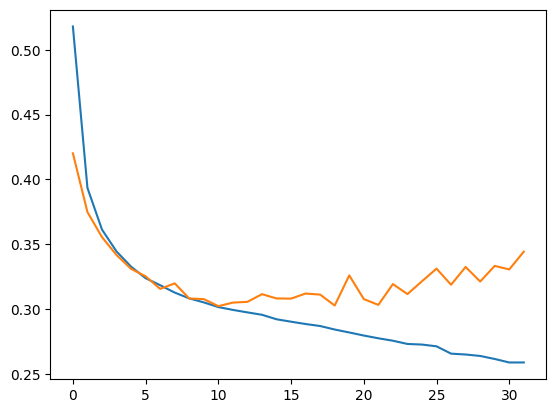

In [16]:
plt.plot(train_loss)
plt.plot(valid_loss)

# validate trained NN

In [20]:
M_pca = np.load(os.path.join(U.data_dir(), 'seds', 'modelb', 'train_sed.modelb.M_pca.w0.npy'))
avg_logsed = np.load(os.path.join(U.data_dir(), 'seds', 'modelb', 'train_sed.modelb.avg_logseds.w0.npy'))
std_logsed = np.load(os.path.join(U.data_dir(), 'seds', 'modelb', 'train_sed.modelb.std_logseds.w0.npy'))

In [ ]:
wave_bins = [(1.5e3, 3.525e3), 
             (3.525e3, 5.5e3), (5.5e3, 7.5e3), # these wavelength ranges are determined by the MILES spectral library wavelength (3525 - 7500)
             (7.5e3, 4e5)]
wave_bin = wave_bins[iwave]

_w = np.load(os.path.join(U.data_dir(), 'seds', 'modelb', 'train_sed.modelb.0.waves.npz'))['arr_0'][0]
wlim = np.ones(len(_w)).astype(bool)
if wave_bin[0] is not None: wlim &= (_w > wave_bin[0])
if wave_bin[1] is not None: wlim &= (_w < wave_bin[1])   
    
logseds = [] 
for seed in range(10):
    logseds.append(np.log10(np.load(os.path.join(U.data_dir(), 'seds', 'modelb', 'train_sed.modelb.%i.seds.npz' % seed))['arr_0'][:,wlim]))
logseds = np.concatenate(logseds)

In [ ]:
y_pred = []
for x, y in valid_dataloader: 
    y_pred.append(forward(best_params, x))
y_pred = np.concatenate(y_pred, axis=0)

y_pred *= std_x_pca
y_pred += avg_x_pca

logsed_pred = np.dot(y_pred, M_pca) * std_logsed + avg_logsed